## This notebook is a demo for

1. Testing the convergence between the grf-approximated covariance matrix to the ground truth diffusion kernel.

In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import math

In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import fast_diffusion_grf_kernel, diffusion_kernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [4]:
# Parameters
num_nodes = 10
graph_type = 'line' # 'line', 'random'
np.random.seed(0)

In [5]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix

In [9]:
ground_truth = diffusion_kernel(adj_matrix=adjacency_matrix, beta=0.1)

In [10]:
grf_matrix = fast_diffusion_grf_kernel(
    adj_matrix=adjacency_matrix,
    walks_per_node=100,
    p_halt=0.1,
    max_walk_length=20,
    beta=0.1
)

In [11]:
# Updated plotting function
def plot_heatmaps(walks_per_node_sample, p_halt_sample, beta_sample):
    # Compute Ground Truth and GRF Matrix
    ground_truth = diffusion_kernel(adjacency_matrix, beta_sample)
    grf_matrix = fast_diffusion_grf_kernel(
        adjacency_matrix,
        walks_per_node=walks_per_node_sample,
        p_halt=p_halt_sample,
        max_walk_length=100,
        beta=beta_sample
    )
    
    # Create the plots
    plt.figure(figsize=(12, 6))
    
    # Heatmap for Ground Truth
    plt.subplot(1, 2, 1)
    sns.heatmap(ground_truth, annot=True, cmap='viridis', cbar=True)
    plt.title(f"Ground Truth (Beta={beta_sample:.2f})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    # Heatmap for GRF Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(grf_matrix, annot=True, cmap='viridis', cbar=True)
    plt.title(f"GRF Matrix (Walks Per Node={walks_per_node_sample}, p_halt={p_halt_sample:.2f})")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    
    plt.tight_layout()
    plt.show()

# Interactive widgets
walks_per_node_slider = widgets.IntSlider(value=20, min=10, max=1000, step=10, description='Walks Per Node:')
p_halt_slider = widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='p_halt:')
beta_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Beta:')  # New slider for beta

# Interactive output
ui = widgets.VBox([walks_per_node_slider, p_halt_slider, beta_slider])
out = widgets.interactive_output(plot_heatmaps, {
    'walks_per_node_sample': walks_per_node_slider,
    'p_halt_sample': p_halt_slider,
    'beta_sample': beta_slider
})

# Display widgets and plots
display(ui, out)

Output()

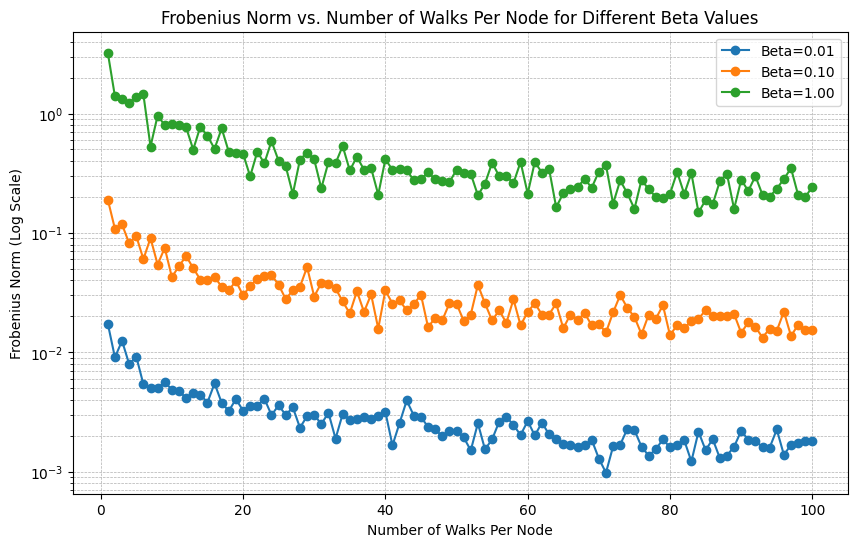

In [12]:
def plot_frobenius_norm(adjacency_matrix, p_halt, beta_values, max_walks_per_node=100):
    """
    Plot Frobenius norm vs. number of walks per node for different beta values.
    """
    ground_truths = {beta: diffusion_kernel(adjacency_matrix, beta) for beta in beta_values}
    walks_range = range(1, max_walks_per_node + 1)

    plt.figure(figsize=(10, 6))
    
    for beta in beta_values:
        norms = []
        ground_truth = ground_truths[beta]
        for walks_per_node in walks_range:
            grf_matrix = fast_diffusion_grf_kernel(adjacency_matrix,
                                                   walks_per_node,
                                                   p_halt,
                                                   max_walk_length=30,
                                                   beta=beta)
                
            # grf_matrix = grf_kernel(adjacency_matrix, walks_per_node, p_halt, 
            #                         modulation_function=diffusion_modulation_function, beta=beta)
            norm = compute_fro(ground_truth, grf_matrix)
            norms.append(norm)
        
        plt.plot(walks_range, norms, marker='o', label=f"Beta={beta:.2f}")

    # Configure plot
    plt.title("Frobenius Norm vs. Number of Walks Per Node for Different Beta Values")
    plt.xlabel("Number of Walks Per Node")
    plt.ylabel("Frobenius Norm (Log Scale)")
    plt.yscale("log")  # Use log scale for y-axis
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage
beta_values = [0.01,0.1,1]  # List of beta values to compare
plot_frobenius_norm(adjacency_matrix, p_halt=0.1, beta_values=beta_values)

In [9]:
def kl_gaussian_zero_mean(Sigma1: np.ndarray, Sigma2: np.ndarray) -> float:
    """
    Compute the KL divergence D_KL(N(0, Sigma1) || N(0, Sigma2)).

    D_KL(N(0, Sigma1) || N(0, Sigma2)) =
        0.5 * [ trace(Sigma2^-1 * Sigma1) - d + ln(|Sigma2| / |Sigma1|) ]

    Args:
        Sigma1 (np.ndarray): Covariance matrix (d x d) for the first Gaussian.
        Sigma2 (np.ndarray): Covariance matrix (d x d) for the second Gaussian.
    
    Returns:
        float: KL divergence (a non-negative scalar).

    Raises:
        np.linalg.LinAlgError: If Sigma2 is singular.
    """
    d = Sigma1.shape[0]
    inv_Sigma2 = np.linalg.inv(Sigma2)  # Might raise LinAlgError if singular
    
    # trace( inv_Sigma2 * Sigma1 )
    trace_term = np.trace(inv_Sigma2 @ Sigma1)
    
    # ln( det(Sigma2) / det(Sigma1) )
    sign1, logdet1 = np.linalg.slogdet(Sigma1)
    sign2, logdet2 = np.linalg.slogdet(Sigma2)
    log_det_ratio = logdet2 - logdet1  # = ln|Sigma2| - ln|Sigma1|
    
    kl_div = 0.5 * (trace_term - d + log_det_ratio)
    return kl_div

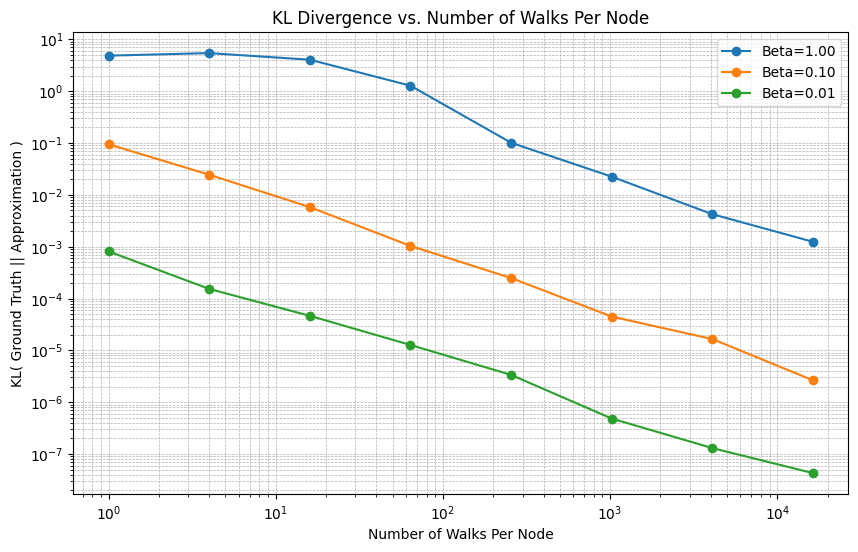

In [16]:
# Parameters
num_nodes = 10
graph_type = 'line' # 'line', 'random'
np.random.seed(0)

if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix


def plot_kl_divergence(adjacency_matrix, p_halt, beta_values, max_walks_per_node=100):
    # Precompute ground truth for all betas
    ground_truths = {
        beta: diffusion_kernel(adjacency_matrix, beta) 
        for beta in beta_values
    }
    
    # Range of walks per node
    walks_range = [1,4,16,64,256,1024,4096,16384]
    plt.figure(figsize=(10, 6))

    for beta in beta_values:
        kl_values = []
        ground_truth_cov = ground_truths[beta]

        for walks_per_node in walks_range:
            approx_cov = fast_diffusion_grf_kernel(
                adjacency_matrix,
                walks_per_node,
                p_halt,
                max_walk_length=30,
                beta=beta
            )

            # Compute KL from ground_truth to approx
            kl_val = kl_gaussian_zero_mean(ground_truth_cov, approx_cov)
            kl_values.append(kl_val)

        plt.plot(walks_range, kl_values, marker='o', label=f"Beta={beta:.2f}")

    plt.title("KL Divergence vs. Number of Walks Per Node")
    plt.xlabel("Number of Walks Per Node")
    plt.xscale("log")
    plt.ylabel("KL( Ground Truth || Approximation )")
    plt.yscale("log")  # Optional: log scale for easier visualization
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
beta_values = [1, 0.1, 0.01]
plot_kl_divergence(adjacency_matrix, p_halt=0.1, beta_values=beta_values, max_walks_per_node=1000)


In [15]:
import numpy as np
import networkx as nx

# Assume these functions are defined:
# - diffusion_kernel
# - fast_diffusion_grf_kernel
# - kl_gaussian_zero_mean

# Parameters
num_nodes = 10
graph_type = 'line'  # 'line', 'random'
np.random.seed(0)

if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)
elif graph_type == 'random':
    probability = 0.1
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    adjacency_matrix = nx.to_numpy_array(G)

def compute_average_gradient_of_log_kl(adjacency_matrix, p_halt, beta, max_walks_per_node=100):
    ground_truth_cov = diffusion_kernel(adjacency_matrix, beta)

    walks_range = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
    log_walks_range = np.log(walks_range)

    kl_values = []

    for walks_per_node in walks_range:
        approx_cov = fast_diffusion_grf_kernel(
            adjacency_matrix,
            walks_per_node,
            p_halt,
            max_walk_length=30,
            beta=beta
        )

        kl_val = kl_gaussian_zero_mean(ground_truth_cov, approx_cov)
        kl_values.append(kl_val)

    kl_values = np.array(kl_values)
    log_kl_values = np.log(kl_values)

    # Perform least-squares linear fit: log(KL) = slope * log(Walks) + intercept
    slope, intercept = np.polyfit(log_walks_range, log_kl_values, deg=1)

    print(f"Least Squares Slope (d(log KL) / d(log Walks)): {slope:.4f}")

# Example usage
beta = 0.1
compute_average_gradient_of_log_kl(adjacency_matrix, p_halt=0.1, beta=beta, max_walks_per_node=1000)


Least Squares Slope (d(log KL) / d(log Walks)): -0.9950


Processing graph sizes: 100%|██████████| 4/4 [00:20<00:00,  5.16s/it]


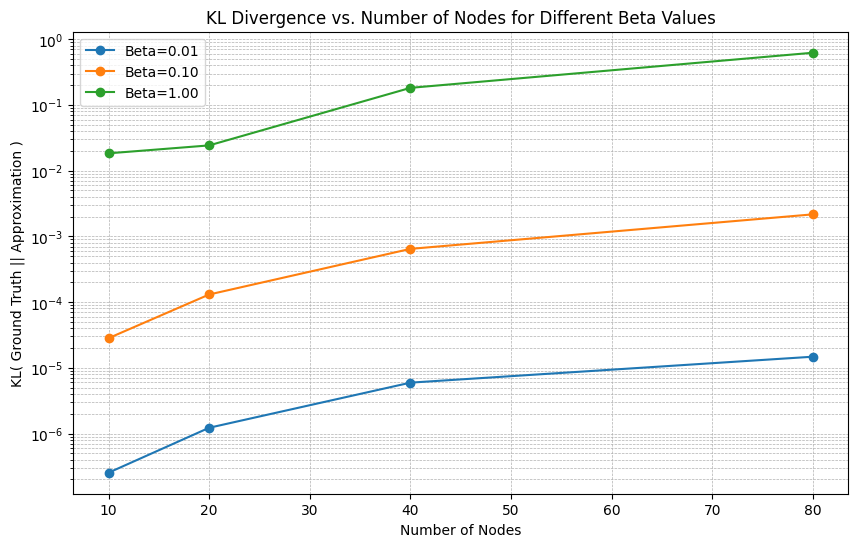

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to generate a random graph adjacency matrix
def generate_random_graph(num_nodes, probability=0.1):
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    return nx.to_numpy_array(G)

# Function to plot KL divergence vs number of nodes
def plot_kl_vs_graph_size(graph_sizes, p_halt, beta_values, num_walks_per_node=1000, edge_probability=0.1):
    kl_results = {beta: [] for beta in beta_values}  # Store KL divergences

    for num_nodes in tqdm(graph_sizes, desc="Processing graph sizes"):
        adjacency_matrix = generate_random_graph(num_nodes, edge_probability)

        # Precompute ground truth diffusion kernels
        ground_truths = {
            beta: diffusion_kernel(adjacency_matrix, beta)
            for beta in beta_values
        }

        for beta in tqdm(beta_values, desc=f"Processing beta values for {num_nodes} nodes", leave=False):
            # Approximate diffusion kernel
            approx_cov = fast_diffusion_grf_kernel(
                adjacency_matrix,
                num_walks_per_node,
                p_halt,
                max_walk_length=30,
                beta=beta
            )

            # Compute KL divergence
            kl_val = kl_gaussian_zero_mean(ground_truths[beta], approx_cov)
            kl_results[beta].append(kl_val)

    # Plot the results
    plt.figure(figsize=(10, 6))
    for beta, kl_values in kl_results.items():
        plt.plot(graph_sizes, kl_values, marker='o', label=f"Beta={beta:.2f}")

    plt.title("KL Divergence vs. Number of Nodes for Different Beta Values")
    plt.xlabel("Number of Nodes")
    plt.ylabel("KL( Ground Truth || Approximation )")
    plt.yscale("log")  # Optional: log scale for easier visualization
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
graph_sizes = [10, 20, 40, 80]
beta_values = [0.01, 0.1, 1.0]
plot_kl_vs_graph_size(graph_sizes, p_halt=0.1, beta_values=beta_values, num_walks_per_node=1000, edge_probability=0.1)


## How Does the GRF Approximation Vary with Graph Scale?

Processing graph sizes: 100%|██████████| 19/19 [02:20<00:00,  7.39s/it]


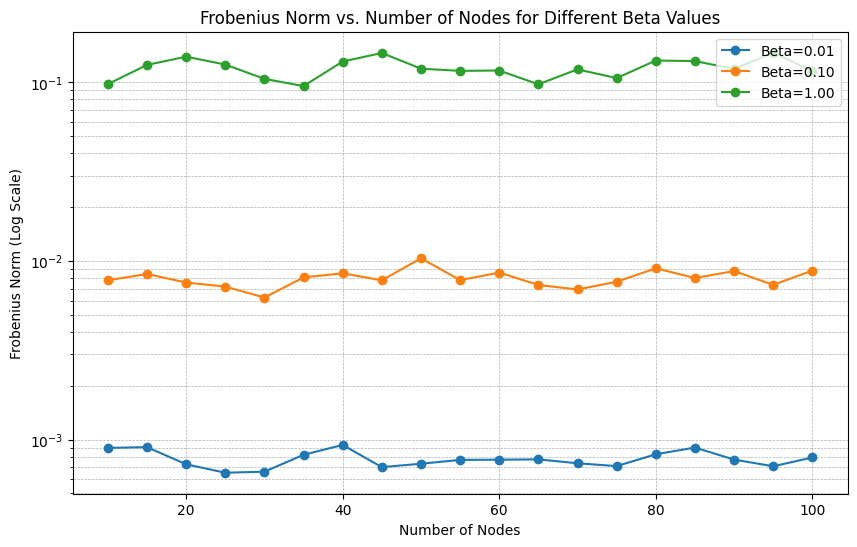

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to generate a random graph adjacency matrix
def generate_random_graph(num_nodes, probability=0.1):
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    return nx.to_numpy_array(G)

# Function to generate a random graph adjacency matrix by average degree
def generate_random_graph_by_degree(num_nodes, average_degree):
    probability = average_degree / (num_nodes - 1)  # Calculate edge probability from average degree
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)
    return nx.to_numpy_array(G)

# Function to plot Frobenius norm vs number of nodes
def plot_frobenius_vs_graph_size(graph_sizes, p_halt, beta_values, num_walks_per_node=1000, average_degree=5):
    fro_results = {beta: [] for beta in beta_values}  # Store Frobenius norms

    for num_nodes in tqdm(graph_sizes, desc="Processing graph sizes"):
        adjacency_matrix = generate_random_graph_by_degree(num_nodes, average_degree=average_degree)

        # Precompute ground truth diffusion kernels
        ground_truths = {
            beta: diffusion_kernel(adjacency_matrix, beta)
            for beta in beta_values
        }

        for beta in tqdm(beta_values, desc=f"Processing beta values for {num_nodes} nodes", leave=False):
            # Approximate diffusion kernel
            approx_cov = fast_diffusion_grf_kernel(
                adjacency_matrix,
                num_walks_per_node,
                p_halt,
                max_walk_length=30,
                beta=beta
            )

            # Compute Frobenius norm
            fro_val = compute_fro(ground_truths[beta], approx_cov)
            fro_results[beta].append(fro_val)

    # Plot the results
    plt.figure(figsize=(10, 6))
    for beta, fro_values in fro_results.items():
        plt.plot(graph_sizes, fro_values, marker='o', label=f"Beta={beta:.2f}")

    plt.title("Frobenius Norm vs. Number of Nodes for Different Beta Values")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Frobenius Norm (Log Scale)")
    plt.yscale("log")  # Optional: log scale for easier visualization
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
graph_sizes = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
beta_values = [0.01, 0.1, 1]
plot_frobenius_vs_graph_size(graph_sizes, p_halt=0.1, beta_values=beta_values, num_walks_per_node=1000, average_degree=5)
